In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn import metrics
from sklearn.metrics import roc_curve, auc


In [2]:
# Hyperparameters
batch_size = 64 
learning_rate = 0.01
num_epochs = 10

# Define the data transformation
transform = transforms.Compose([ 
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

In [3]:
# Load the dataset

train_dataset = datasets.ImageFolder(root='train/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print('Training data Loaded')

test_dataset = datasets.ImageFolder(root='test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print('Testing data Loaded')


Training data Loaded
Testing data Loaded


In [4]:
# Define the model

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # dataset has 2 classes


C:\Users\Chitra S. Lakhani\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Chitra S. Lakhani\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# cuda is not available, using cpu for parallel processing

device = torch.device("cpu")
model = model.to(device)


In [6]:
# Define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


In [7]:
# Training the model

import time
start_1 = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_2 = time.time()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    end_2 = time.time()
    print(f'Time taken for {epoch} is {end_2 - start_2}')
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
end_1 = time.time()
print(f'Total time take to run {num_epochs} epochs: {end_1 - start_1}')

Time taken for 0 is 532.6477055549622
Epoch 1/10, Loss: 0.3202
Time taken for 1 is 528.7237617969513
Epoch 2/10, Loss: 0.2164
Time taken for 2 is 551.7747972011566
Epoch 3/10, Loss: 0.1688
Time taken for 3 is 588.4833111763
Epoch 4/10, Loss: 0.1355
Time taken for 4 is 545.4345893859863
Epoch 5/10, Loss: 0.1125
Time taken for 5 is 532.7075002193451
Epoch 6/10, Loss: 0.0867
Time taken for 6 is 532.0015978813171
Epoch 7/10, Loss: 0.0898
Time taken for 7 is 529.0845372676849
Epoch 8/10, Loss: 0.0613
Time taken for 8 is 544.856644153595
Epoch 9/10, Loss: 0.0483
Time taken for 9 is 547.0319926738739
Epoch 10/10, Loss: 0.0370
Total time take to run 10 epochs: 5432.7464373111725


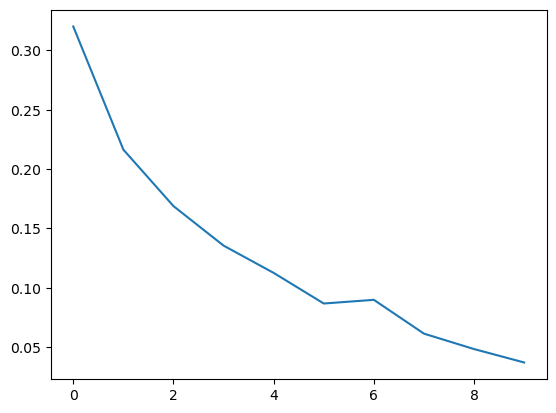

In [12]:
arr_loss_10_epoch = [0.3202, 0.2164, 0.1688, 0.1355, 0.1125, 0.0867, 0.0898, 0.0613, 0.0483, 0.0370]
plt.plot(arr_loss_10_epoch)

In [39]:
# Testing loop
model.eval()
correct = 0
total = 0
actual = []
pred = []
all_labels = []
all_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        probs = nn.functional.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in labels:
            actual.append(i)
        for x in predicted:
            pred.append(x)

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 90.60%


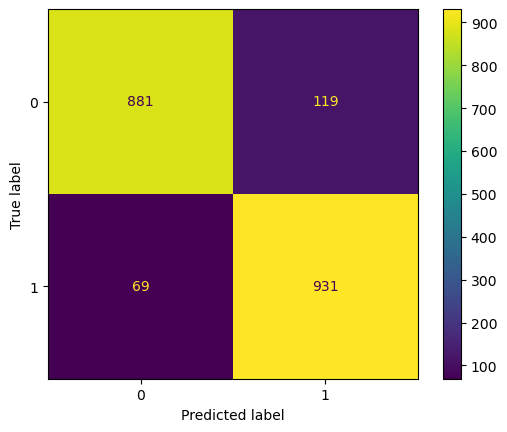

In [40]:
conf_mat = metrics.confusion_matrix(actual, pred)
display_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [0,1])
display_plot.plot()
plt.show()

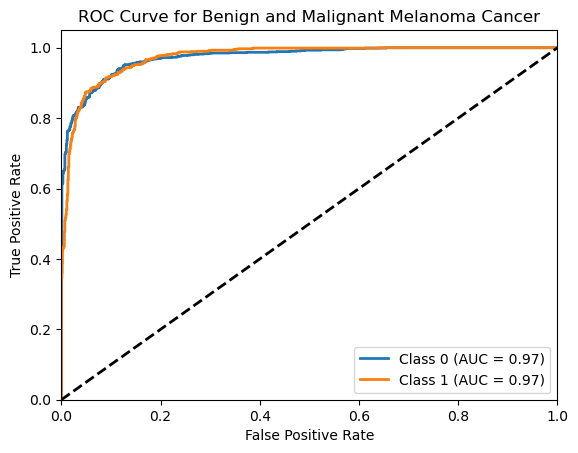

In [43]:

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Benign and Malignant Melanoma Cancer')
plt.legend(loc="lower right")
plt.show()

In [51]:
final_pred = pd.DataFrame({'actual':actual,'pred':pred})
final_pred.to_csv('preds.csv')


In [52]:
final_prob = pd.DataFrame(all_probs, columns=[f'Class_{i}' for i in range(all_probs.shape[1])])
final_prob['all_labels'] = all_labels
final_prob.to_csv('probs.csv')